# Importing libraries and dependencies

In [1]:
import pandas as pd
import requests
import numpy as np
import geocoder
import folium
import requests 
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import xml
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import geopy
from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim 
from bs4 import BeautifulSoup

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print("All Required Libraries Imported!")

All Required Libraries Imported!


# Data Cleaning and extracting

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
extracting_data = requests.get(url).text

In [3]:
#Converting content of PostalCode HTML table as dataframe
table_contents=[]
soup = BeautifulSoup(extracting_data, 'html.parser')
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['Postalcode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

In [4]:
table_contents

[{'Postalcode': 'M3A', 'Borough': 'North York', 'Neighborhood': 'Parkwoods'},
 {'Postalcode': 'M4A',
  'Borough': 'North York',
  'Neighborhood': 'Victoria Village'},
 {'Postalcode': 'M5A',
  'Borough': 'Downtown Toronto',
  'Neighborhood': 'Regent Park, Harbourfront'},
 {'Postalcode': 'M6A',
  'Borough': 'North York',
  'Neighborhood': 'Lawrence Manor, Lawrence Heights'},
 {'Postalcode': 'M7A',
  'Borough': "Queen's Park",
  'Neighborhood': 'Ontario Provincial Government'},
 {'Postalcode': 'M9A',
  'Borough': 'Etobicoke',
  'Neighborhood': 'Islington Avenue'},
 {'Postalcode': 'M1B',
  'Borough': 'Scarborough',
  'Neighborhood': 'Malvern, Rouge'},
 {'Postalcode': 'M3B',
  'Borough': 'North York',
  'Neighborhood': 'Don Mills North'},
 {'Postalcode': 'M4B',
  'Borough': 'East York',
  'Neighborhood': 'Parkview Hill, Woodbine Gardens'},
 {'Postalcode': 'M5B',
  'Borough': 'Downtown Toronto',
  'Neighborhood': 'Garden District, Ryerson'},
 {'Postalcode': 'M6B', 'Borough': 'North York', 'N

In [5]:
df = pd.DataFrame(table_contents)

In [6]:
df.shape

(103, 3)

In [7]:
df.head()

,Postalcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


In [8]:
df = df.groupby(['Postalcode','Borough'])['Neighborhood'].apply(', '.join).reset_index()
df.head()

,Postalcode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [9]:
df[df['Postalcode']=="M3A"]

,Postalcode,Borough,Neighborhood
25,M3A,North York,Parkwoods


In [10]:
df = df.dropna()
empty = 'Not assigned\n'
df = df[(df.Postalcode != empty ) & (df.Borough != empty) & (df.Neighborhood != empty)]

In [11]:
df.shape

(103, 3)

In [12]:
def neighborhood_list(grouped):    
    return ', '.join(sorted(grouped['Neighborhood'].tolist()))
                    
grp = df.groupby(['Postalcode', 'Borough'])
df2 = grp.apply(neighborhood_list).reset_index(name='Neighborhood')

In [13]:
print(df2.shape)
df2.head()

(103, 3)


,Postalcode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [14]:
df2.describe()

,Postalcode,Borough,Neighborhood
count,103,103,103
unique,103,15,103
top,M3L,North York,Davisville North
freq,1,24,1


In [15]:
def get_latilong(postal_code):
    lati_long_coords = None
    while(lati_long_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code))
        lati_long_coords = g.latlng
    return lati_long_coords

In [16]:
get_latilong("M3A")

[43.75245000000007, -79.32990999999998]

In [ ]:
# Retrieving Postal Code Co-ordinates
postal_codes = df2['Postalcode']    
coords = [ get_latilong(postal_code) for postal_code in postal_codes.tolist() ]

In [18]:
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df2['Latitude'] = df_coords['Latitude']
df2['Longitude'] = df_coords['Longitude']

In [19]:
df2[df2.Postalcode == 'M3A']

,Postalcode,Borough,Neighborhood,Latitude,Longitude
25,M3A,North York,Parkwoods,43.75245,-79.32991


In [20]:
df2[df2.Postalcode == 'M5G']

,Postalcode,Borough,Neighborhood,Latitude,Longitude
57,M5G,Downtown Toronto,Central Bay Street,43.65609,-79.38493


In [21]:
df2.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.81139,-79.19662
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.78574,-79.15875
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.76575,-79.17470
3,M1G,Scarborough,Woburn,43.76812,-79.21761
4,M1H,Scarborough,Cedarbrae,43.76944,-79.23892


In [22]:
from geopy import Nominatim
address = 'Scarborough,Toronto'

In [23]:
geolocator = Nominatim(user_agent="Coursera-capstone-project")
location = geolocator.geocode(address)
latitude_x = location.latitude
longitude_y = location.longitude
print('The Geograpical Co-ordinate of Seattle,Washington are {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of Seattle,Washington are 43.7729744, -79.2576479.


# Map

In [24]:
map_Scarborough = folium.Map(location=[latitude_x, longitude_y], zoom_start=10)

for lat, lng, nei in zip(df2['Latitude'], df2['Longitude'], df2['Neighborhood']):
    
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Scarborough)  
    
map_Scarborough

In [25]:
address = 'Scarborough,Toronto'

geolocator = Nominatim(user_agent = "Coursera-capstone-project")
location = geolocator.geocode(address)
latitude_n1 = location.latitude
longitude_n1 = location.longitude
print('The Geograpical Co-ordinate of Neighborhood_1 are {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of Neighborhood_1 are 43.7729744, -79.2576479.


In [26]:
# @hiddel_cell
CLIENT_ID = 'CHHMF0324VJ4S4BR445TFQLQZSTQGTZUDDLSCXXMN3MGFY4F' # my Foursquare ID
CLIENT_SECRET = 'VTAHFIRGU0K3FBKFTLKRDQKUQXGFSHT3AAAPQFCGAUWLXTXF' # my Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: '+CLIENT_ID)
print('CLIENT_SECRET: '+CLIENT_SECRET)

Your credentails:
CLIENT_ID: CHHMF0324VJ4S4BR445TFQLQZSTQGTZUDDLSCXXMN3MGFY4F
CLIENT_SECRET: VTAHFIRGU0K3FBKFTLKRDQKUQXGFSHT3AAAPQFCGAUWLXTXF


In [27]:
radius = 700 
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude_n1, 
   longitude_n1, 
    radius, 
   LIMIT)
results = requests.get(url).json()

In [28]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

results

{'meta': {'code': 200, 'requestId': '60c5e361412fbb3a574fda0d'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Scarborough City Centre',
  'headerFullLocation': 'Scarborough City Centre, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 46,
  'suggestedBounds': {'ne': {'lat': 43.77927440630001,
    'lng': -79.24893946630628},
   'sw': {'lat': 43.766674393699994, 'lng': -79.26635633369371}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4c648dbdf07e2d7fc4aa8f50',
       'name': 'Hot Topic',
       'location': {'address': '300 Borough Dr.',
        'crossStreet': 'at Scarborough Town Centre',
        'lat': 43.775450021914345,
        'lng': -79.257928653

In [29]:
 def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# Nearby Venues

In [30]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Hot Topic,"[{'id': '4bf58dd8d48988d103951735', 'name': 'C...",43.775450,-79.257929
1,Tommy Hilfiger,"[{'id': '4bf58dd8d48988d103951735', 'name': 'C...",43.776015,-79.257369
2,lululemon athletica,"[{'id': '4bf58dd8d48988d103951735', 'name': 'C...",43.775517,-79.258423
3,New York Fries - Scarborough TC,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",43.775135,-79.256858
4,Subway,"[{'id': '4bf58dd8d48988d1c5941735', 'name': 'S...",43.775102,-79.257115


# Nearby Venue Categories

In [31]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(5)

,name,categories,lat,lng
0,Hot Topic,Clothing Store,43.775450,-79.257929
1,Tommy Hilfiger,Clothing Store,43.776015,-79.257369
2,lululemon athletica,Clothing Store,43.775517,-79.258423
3,New York Fries - Scarborough TC,Restaurant,43.775135,-79.256858
4,Subway,Sandwich Place,43.775102,-79.257115


In [32]:
nearby_venues['categories'].value_counts()

Clothing Store          5
Restaurant              5
Coffee Shop             3
Gas Station             2
Department Store        2
Intersection            2
Sandwich Place          2
Pharmacy                2
Discount Store          1
Video Game Store        1
American Restaurant     1
Pizza Place             1
Electronics Store       1
Toy / Game Store        1
Shopping Mall           1
Men's Store             1
Sporting Goods Shop     1
Bank                    1
Fish & Chips Shop       1
Food Court              1
Italian Restaurant      1
Bar                     1
Plaza                   1
Fast Food Restaurant    1
Women's Store           1
Mobile Phone Shop       1
Movie Theater           1
Jewelry Store           1
Gym                     1
Grocery Store           1
Wings Joint             1
Name: categories, dtype: int64

In [33]:
#Top 10 categories
nearby_venues['categories'].value_counts()[:10]

Clothing Store      5
Restaurant          5
Coffee Shop         3
Gas Station         2
Department Store    2
Intersection        2
Sandwich Place      2
Pharmacy            2
Discount Store      1
Video Game Store    1
Name: categories, dtype: int64

In [34]:
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # making GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)
  

In [35]:
# Nearby Venues
Scarborough_venues = getNearbyVenues(names=df2['Neighborhood'],
                                   latitudes=df2['Latitude'],
                                   longitudes=df2['Longitude']
                                  )

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Don Mills South
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
The Danforth  East
The Danforth West, Riverdale


In [36]:
print('There are {} Uniques Categories.'.format(len(Scarborough_venues['Venue Category'].unique())))
Scarborough_venues.groupby('Neighborhood').count().head()

There are 297 Uniques Categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,25,25,25,25,25,25
"Alderwood, Long Branch",8,8,8,8,8,8
"Bathurst Manor, Wilson Heights, Downsview North",9,9,9,9,9,9
Bayview Village,7,7,7,7,7,7
"Bedford Park, Lawrence Manor East",24,24,24,24,24,24


In [37]:
# one hot encoding
Scarborough_onehot = pd.get_dummies(Scarborough_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Scarborough_onehot['Neighborhood'] = Scarborough_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Scarborough_onehot.columns[-1]] + list(Scarborough_onehot.columns[:-1])
Scarborough_onehot = Scarborough_onehot[fixed_columns]
Scarborough_grouped = Scarborough_onehot.groupby('Neighborhood').mean().reset_index()
Scarborough_onehot.head(5)

,Zoo Exhibit,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Stadium,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hakka Restaurant,Halal Restaurant,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Paper / Office Supplies Store,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,Rock Climbing Spot,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Seafood Restaurant,Shanghai Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stationery Store,Steakhouse,Storage Facility,Street Art,Strip Club,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Thea

In [38]:
num_top_venues = 5
for hood in Scarborough_grouped['Neighborhood']:
    print("---- "+hood+" ----")
    temp =Scarborough_grouped[Scarborough_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Agincourt ----
                 venue  freq
0        Shopping Mall  0.08
1          Pizza Place  0.04
2  Japanese Restaurant  0.04
3         Skating Rink  0.04
4  Shanghai Restaurant  0.04


---- Alderwood, Long Branch ----
            venue  freq
0    Dance Studio  0.12
1     Pizza Place  0.12
2     Gas Station  0.12
3  Sandwich Place  0.12
4     Coffee Shop  0.12


---- Bathurst Manor, Wilson Heights, Downsview North ----
               venue  freq
0        Coffee Shop  0.22
1               Park  0.22
2  Mobile Phone Shop  0.11
3   Sushi Restaurant  0.11
4        Pizza Place  0.11


---- Bayview Village ----
              venue  freq
0             Trail  0.29
1              Park  0.14
2       Flower Shop  0.14
3           Dog Run  0.14
4  Asian Restaurant  0.14


---- Bedford Park, Lawrence Manor East ----
              venue  freq
0    Sandwich Place  0.08
1        Restaurant  0.08
2       Coffee Shop  0.08
3       Pizza Place  0.04
4  Greek Restaurant  0.04


---- Berczy Park 

           venue  freq
0       Pharmacy  0.18
1  Grocery Store  0.09
2   Skating Rink  0.09
3           Café  0.09
4         Bakery  0.09


---- Kennedy Park, Ionview, East Birchmount Park ----
               venue  freq
0     Discount Store  0.33
1         Hobby Shop  0.17
2        Bus Station  0.17
3        Coffee Shop  0.17
4  Convenience Store  0.17


---- Kensington Market, Chinatown, Grange Park ----
                           venue  freq
0                           Café  0.07
1  Vegetarian / Vegan Restaurant  0.06
2                            Bar  0.04
3                    Coffee Shop  0.04
4                    Art Gallery  0.03


---- Kingsview Village, St. Phillips, Martin Grove Gardens, Richview Gardens ----
                 venue  freq
0       Sandwich Place   0.2
1          Coffee Shop   0.2
2  American Restaurant   0.2
3             Pharmacy   0.2
4     Business Service   0.2


---- Lawrence Manor, Lawrence Heights ----
                  venue  freq
0        Clothing Store

                venue  freq
0         Pizza Place  0.17
1  African Restaurant  0.17
2    Halal Restaurant  0.17
3          Hookah Bar  0.17
4         Gas Station  0.17


---- Willowdale South ----
                  venue  freq
0           Coffee Shop  0.10
1   Japanese Restaurant  0.07
2      Ramen Restaurant  0.06
3           Pizza Place  0.06
4  Fast Food Restaurant  0.06


---- Willowdale West ----
           venue  freq
0    Supermarket  0.14
1    Pizza Place  0.14
2    Coffee Shop  0.14
3       Pharmacy  0.14
4  Grocery Store  0.14


---- Willowdale, Newtonbrook ----
                       venue  freq
0          Korean Restaurant  0.26
1                Coffee Shop  0.11
2                       Café  0.11
3  Middle Eastern Restaurant  0.07
4                        Gym  0.04


---- Woburn ----
                  venue  freq
0  Fast Food Restaurant  0.25
1           Coffee Shop  0.25
2    Chinese Restaurant  0.25
3                  Park  0.25
4           Zoo Exhibit  0.00


---- Woodb

In [39]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

# Most common venues near neighborhood

In [40]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Scarborough_grouped['Neighborhood']

for ind in np.arange(Scarborough_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Scarborough_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Shopping Mall,Pizza Place,Japanese Restaurant,Skating Rink,Shanghai Restaurant,Café,Supermarket,Sushi Restaurant,Sandwich Place,Latin American Restaurant
1,"Alderwood, Long Branch",Dance Studio,Pizza Place,Gas Station,Sandwich Place,Coffee Shop,Convenience Store,Pub,Gym,Zoo Exhibit,New American Restaurant
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Park,Mobile Phone Shop,Sushi Restaurant,Pizza Place,Men's Store,Sandwich Place,Music Venue,Museum,Movie Theater
3,Bayview Village,Trail,Park,Flower Shop,Dog Run,Asian Restaurant,Gas Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop
4,"Bedford Park, Lawrence Manor East",Sandwich Place,Restaurant,Coffee Shop,Pizza Place,Greek Restaurant,Sushi Restaurant,Liquor Store,Sports Club,Thai Restaurant,Italian Restaurant


# K-means clustering approach

In [41]:
# Using K-Means to cluster neighborhood into 3 clusters
Scarborough_grouped_clustering = Scarborough_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=3, random_state=0).fit(Scarborough_grouped_clustering)
kmeans.labels_

array([2, 2, 0, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2,
       2, 0, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0])

In [56]:
 neighborhoods_venues_sorted.insert(0, 'Cluster_Labels', kmeans.labels_)

Scarborough_merged =df2.iloc[:16,:]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Scarborough_merged = Scarborough_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
# Scarborough_merged.drop("Cluster Lables")


In [57]:
Scarborough_merged.head()# check the last columns!

,Postalcode,Borough,Neighborhood,Latitude,Longitude,Cluster_Labels,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Malvern, Rouge",43.81139,-79.19662,2,2,Zoo Exhibit,Construction & Landscaping,Fast Food Restaurant,Financial or Legal Service,Pilates Studio,New American Restaurant,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.78574,-79.15875,2,2,Fish & Chips Shop,Home Service,Bar,Zoo Exhibit,Modern European Restaurant,New American Restaurant,Music Venue,Museum,Movie Theater,Monument / Landmark
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.76575,-79.17470,0,0,Park,Athletics & Sports,Gymnastics Gym,Gym / Fitness Center,Zoo Exhibit,Molecular Gastronomy Restaurant,New American Restaurant,Music Venue,Museum,Movie Theater
3,M1G,Scarborough,Woburn,43.76812,-79.21761,0,0,Fast Food Restaurant,Coffee Shop,Chinese Restaurant,Park,Zoo Exhibit,Molecular Gastronomy Restaurant,New American Restaurant,Music Venue,Museum,Movie Theater
4,M1H,Scarborough,Cedarbrae,43.76944,-79.23892,2,2,Thai Restaurant,Playground,Bakery,Bank,Lounge,Hakka Restaurant,Caribbean Restaurant,Athletics & Sports,Gas Station,Museum


# Map of Clusters

In [59]:
kclusters=10
# create map
map_clusters = folium.Map(location=[latitude_x, longitude_y], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)
# add markers to the map

markers_colors = []
for lat, lon, nei , cluster in zip(Scarborough_merged['Latitude'], 
                                   Scarborough_merged['Longitude'], 
                                   Scarborough_merged['Neighborhood'], 
                                   Scarborough_merged['Cluster_Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

['#8000ff', '#4856fb', '#10a2f0', '#2adddd', '#62fbc4', '#9cfba4', '#d4dd80', '#ffa256', '#ff562c', '#ff0000']


In [60]:
df1=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 0,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
df3=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 1,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
df4=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 2,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]

In [61]:
Scarborough_Avg_HousingPrice=pd.DataFrame({"Neighborhood":df2["Neighborhood"],
                                      "Average_Housing_Price":[335000.0,286600.0,175000.0,225900.0,219400.0,
                                                               573900.0,225000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,225000.0,370500.,255400.0,433500.0,433500.0,
                                                               435000.0,289500.0,265000.0,285900.0,239400.0,
                                                               589900.0,295000.0,380500.0,378500.0,438500.0,229200.0,
                                                               229200.0,365000.0,388500.,285400.0,493500.0,477500.0,378000.0,316600.0,195000.0,225900.0,219400.0,
                                                               573900.0,367000.0,370500.0,370500.0,363500.0,279200.0,
                                                               279200.0,271000.0,370500.,255400.0,383500.0,433500.0,335000.0,286600.0,185000.0,225900.0,219400.0,
                                                               573900.0,329000.0,370500.0,370500.0,533500.0,279200.0,
                                                               279200.0,375000.0,370500.,255400.0,493500.0,433500.0,335000.0,286600.0,165000.0,225900.0,219400.0,
                                                               573900.0,425000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,195000.0,370500.,255400.0,403500.0,433500.0,335000.0,286600.0,187000.0,225900.0,219400.0,
                                                               573900.0,325000.0,370500.0,370500.0,333500.0,279200.0,
                                                               279200.0,289000.0,370500.,255400.0,413500.0,433500.0,254800.0
                                                              
                                                              
                                                              ]})

In [62]:
Scarborough_Avg_HousingPrice.set_index('Neighborhood',inplace=True,drop=True)

<AxesSubplot:xlabel='Neighborhood'>

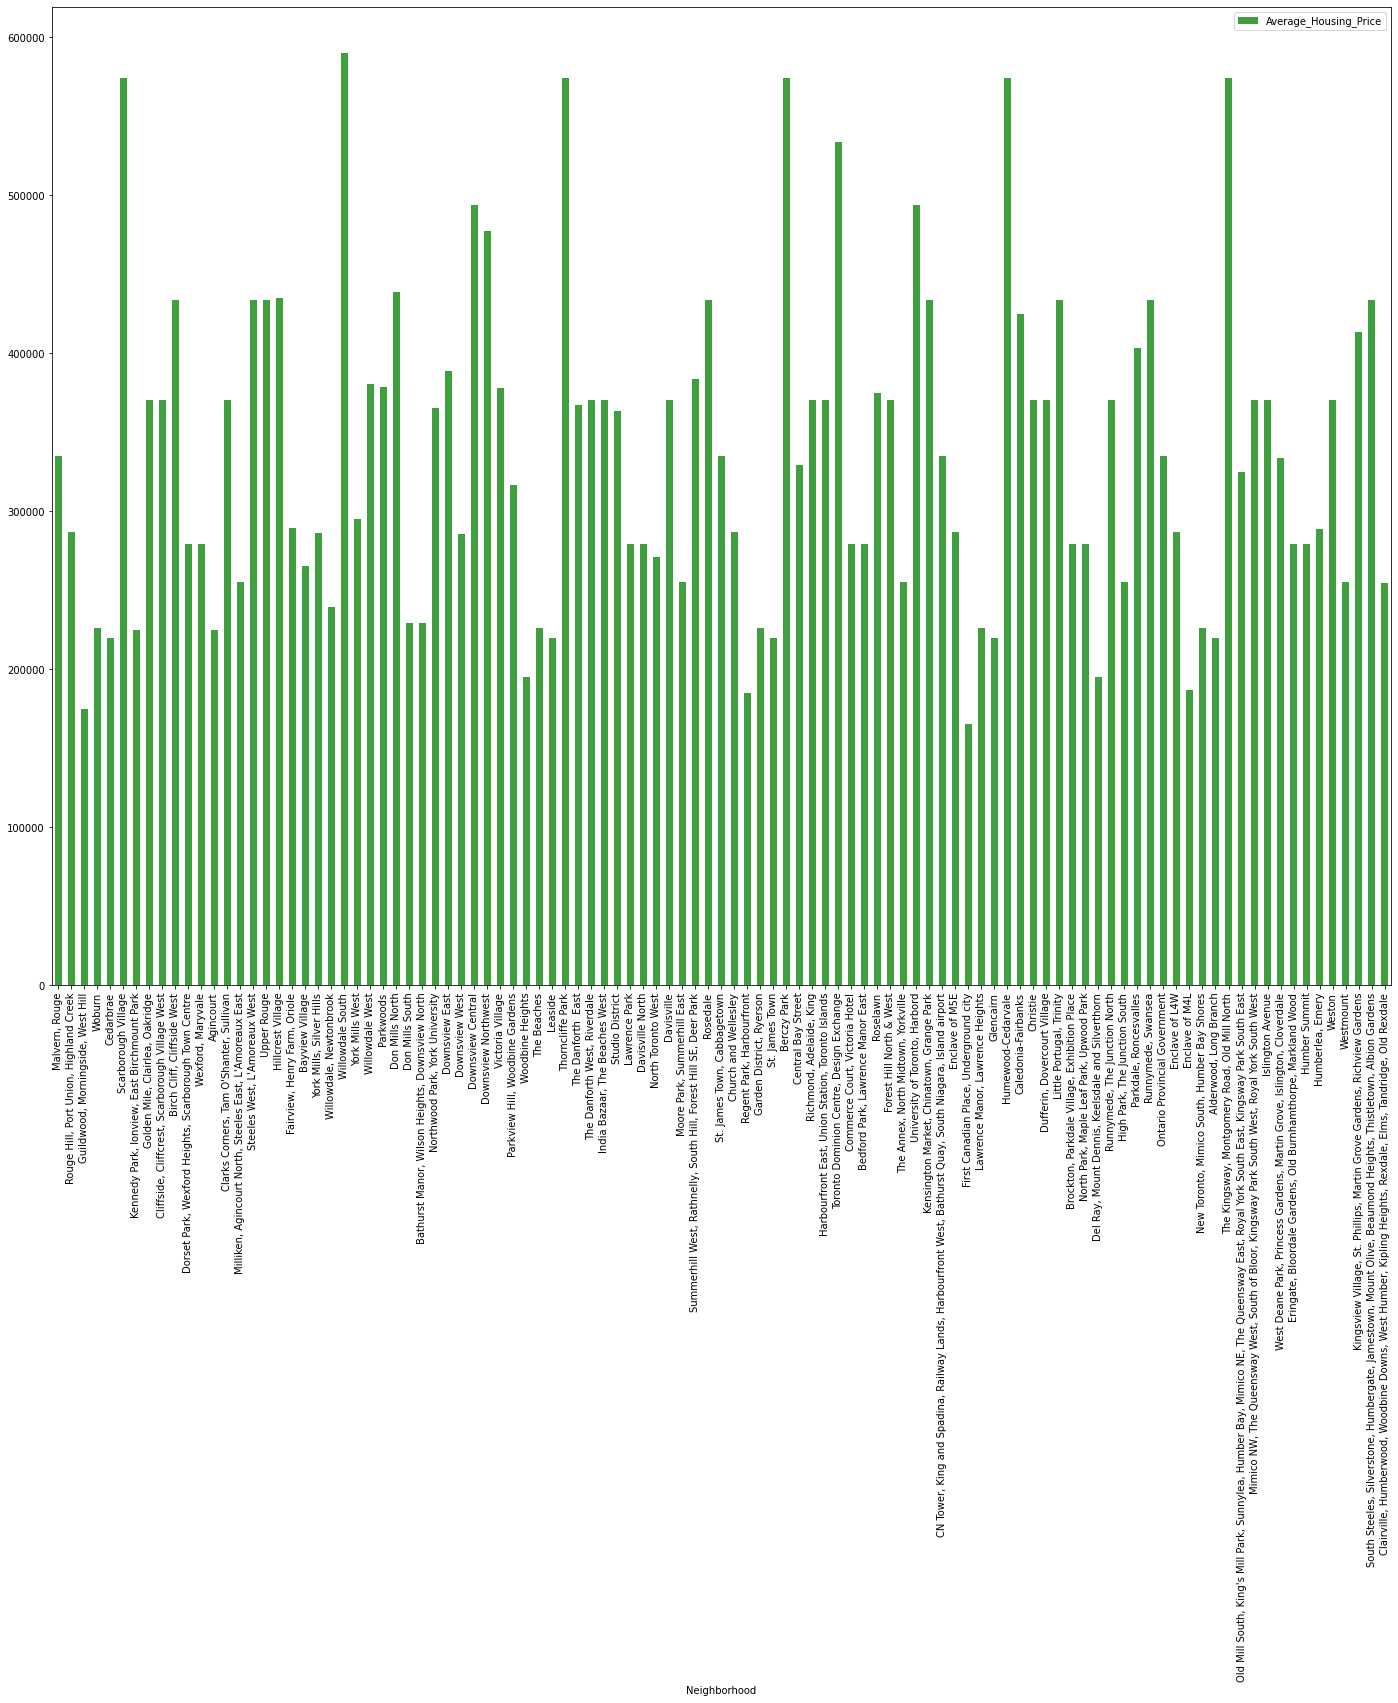

In [63]:
Scarborough_Avg_HousingPrice.plot(kind='bar',figsize=(24,18),alpha=0.75,color="green")

# School rating by clusters

In [64]:
clusters=pd.DataFrame({"Cluster1":df1["Neighborhood"],
                      "Cluster2":df2["Neighborhood"],
                      "Cluster4":df3["Neighborhood"]})
clusters = clusters.replace(np.nan, '', regex=True)

In [65]:
new_Scarborough=Scarborough_merged.set_index("Neighborhood",drop=True)
#Source:https://www.greatschools.org
Scarborough_school_ratings=pd.DataFrame({"Neighborhood":df["Neighborhood"],
                                      "Top School Rating":[7,9,5,8,10,10,7,10,1,2,1,2,7,2,3,2,6,
                                                           5,4,8,9,9,6,6,4,5,4,6,8,10,8,9,6,2,
                                                           10,2,5,8,9,6,6,10,8,9,1,2,3,4,5,6,9,
                                                           8,5,9,6,9,6,4,8,10,2,5,6,3,9,8,7,
                                                           7,8,5,8,9,1,5,4,7,2,3,6,6,9,4,8,7,
                                                           4,8,9,2,6,4,7,5,10,4,6,8,9,7,5,6,5,8,7
                                                           ]})

In [66]:
Scarborough_school_ratings.set_index('Neighborhood',inplace=True,drop=True)

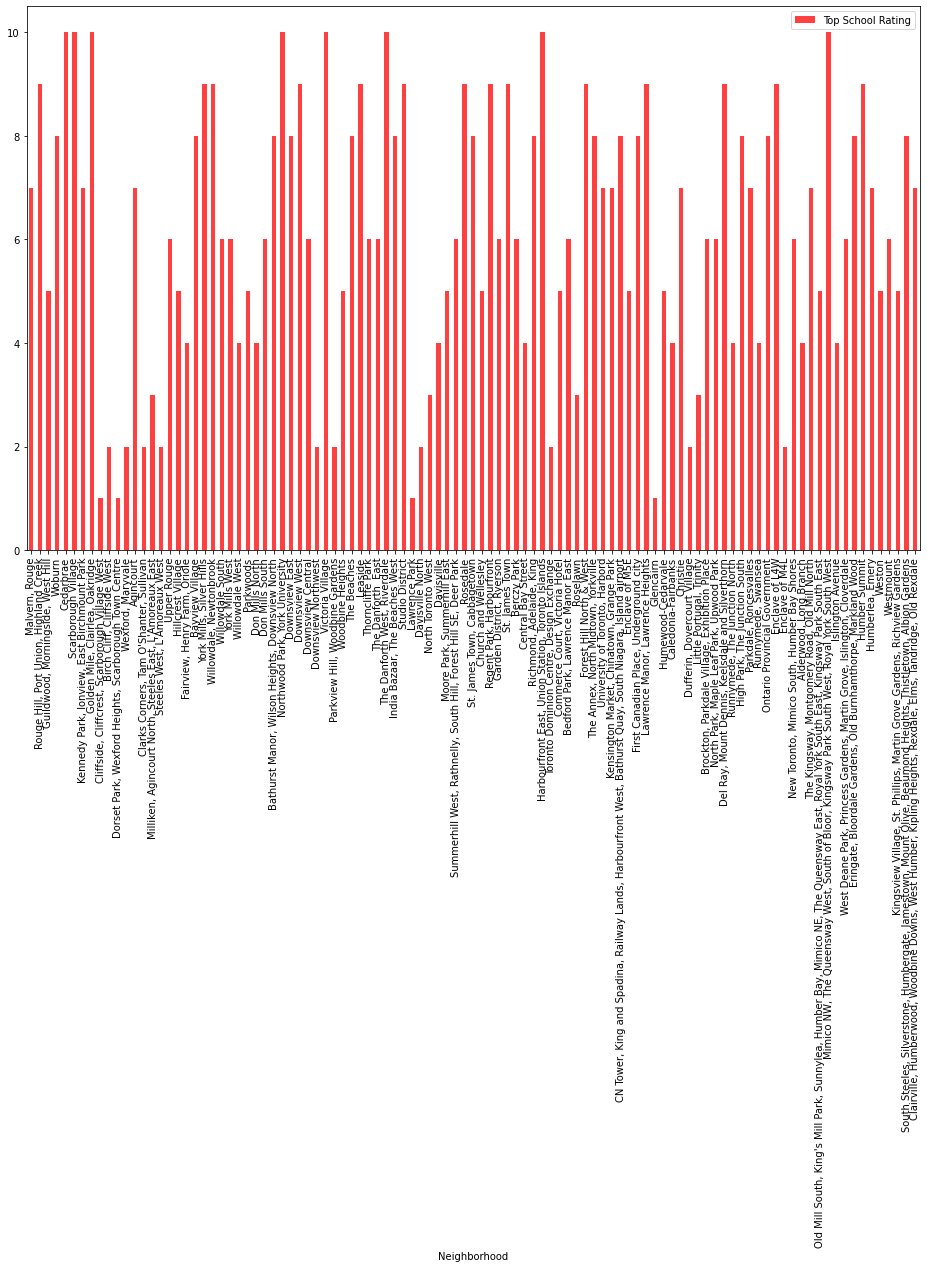

In [67]:
Scarborough_school_ratings.plot(kind='bar',figsize=(16,10),color='red',alpha=0.75);

Conclusion: In this project, using k-means cluster algorithm I separated the neighborhood into 10(Ten) different clusters and for 103 different lattitude and logitude from dataset, which have very-similar neighborhoods around them. Using the charts above results presented to a particular neighborhood based on average house prices and school rating have been made.